In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


from pandas import Series, DataFrame

from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.externals.six import StringIO

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

C:\Users\LinDu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [201]:
df = pd.read_csv("Default.csv")
df= df.drop(['Unnamed: 0'],axis =1)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


## 2) Convert default and student to categorical variables.

In [202]:
def get_y(y):
    if y == "Yes":
        return 1
    else:
        return 0

In [203]:
df['default'] = df['default'].apply(lambda y : get_y(y))
df['student'] = df['student'].apply(lambda y : get_y(y))

## 3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no. 

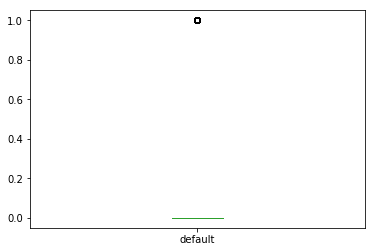

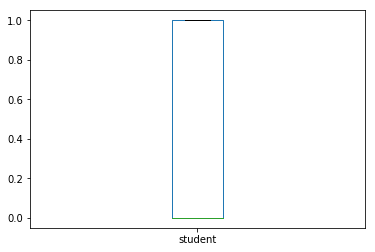

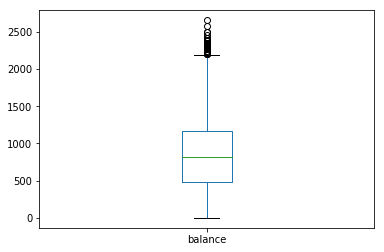

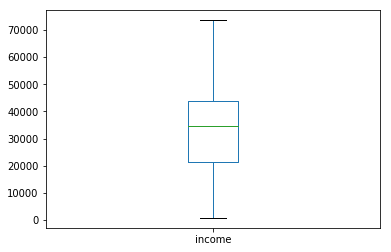

(<matplotlib.axes._subplots.AxesSubplot at 0x5b4740fff28>, None)

In [222]:
df['default'].plot.box(), plt.show()
df['student'].plot.box(), plt.show()
df['balance'].plot.box(), plt.show()
df['income'].plot.box(), plt.show()

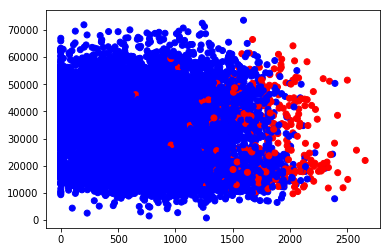

In [57]:
plt.scatter(df['balance'],df['income'],c=df['default'],cmap=matplotlib.colors.ListedColormap(['blue','red']))
plt.show()

## 4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

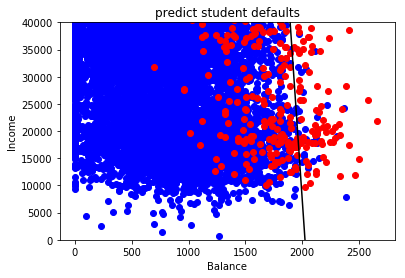

In [241]:
X = df[['balance','income']]
y = df['default']

# Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)

logreg = linear_model.LogisticRegression(penalty='l1')
clf = logreg.fit(X_train,y_train)

coef = clf.coef_
a = coef[0]
b = clf.intercept_

x = np.arange(0, 2600, 1)
y = (b + a[0] * x) / -a[1]

plt.scatter(df.balance[df['default']==0], df.income[df['default']==0],c='blue')
plt.scatter(df.balance[df['default']==1], df.income[df['default']==1],c='red')
plt.plot(x, y, c = 'black')
plt.ylim(0, 40000)
plt.title('predict student defaults')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()

AUC ROC = 0.953755


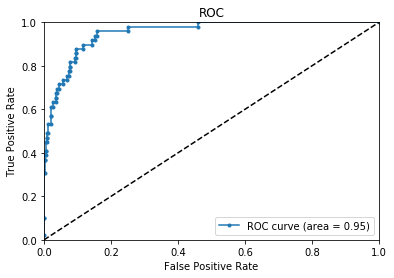

In [245]:
# Computation of AUC ROC
probas = logreg.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC ROC = %f" % roc_auc)

# Plot AUC ROC
plt.clf()
plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

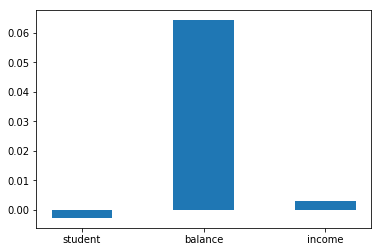

Coefficients:  [-0.00280049  0.06434194  0.00306679]


In [235]:
X = df[['student','balance','income']]
y = df['default']
scaler = StandardScaler() 
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

alpha = np.logspace(-5, -1, 100)
score = []

for a in alpha:
    regr = Ridge(alpha = a)
    regr.fit(X_train, y_train)
    score.append(regr.score(X_test, y_test))
    
idx = np.array(score).argmax()
regr = Ridge(alpha = alpha[idx])
regr.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), regr.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('student', 'balance','income'))
rects = ax.patches
plt.show()
print('Coefficients: ', regr.coef_)

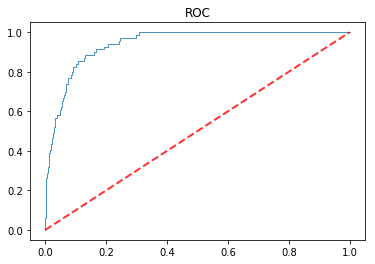

AUC ROC = 0.943545


In [237]:
def get_auc(X,y,fit):
    probas_ = fit.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

LR = LogisticRegression(penalty='l1', C= alpha[idx])
lreg = LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,lreg)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC')
plt.show()
print("AUC ROC = %f" % roc_auc)



## 6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

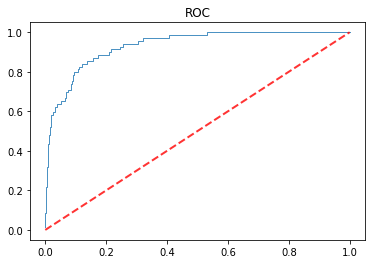

AUC ROC = 0.933601


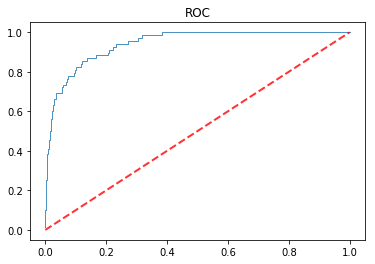

AUC ROC = 0.943117


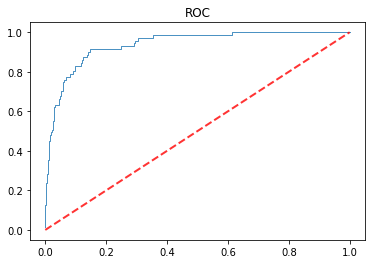

AUC ROC = 0.939529


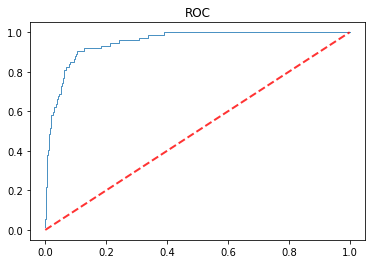

AUC ROC = 0.952555


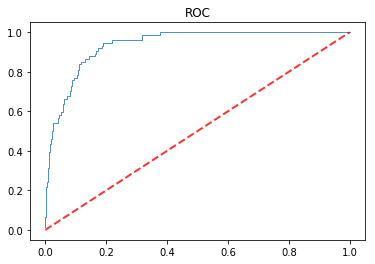

AUC ROC = 0.938242


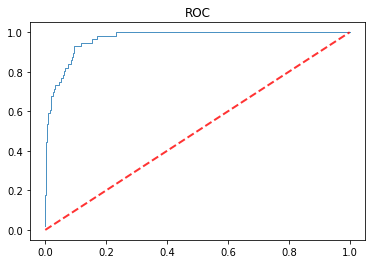

AUC ROC = 0.968998


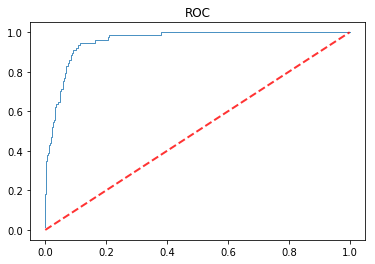

AUC ROC = 0.959276


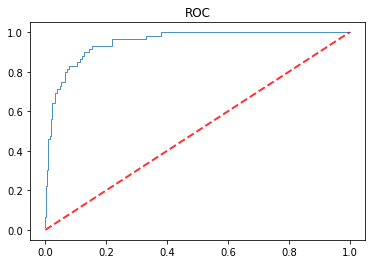

AUC ROC = 0.952087


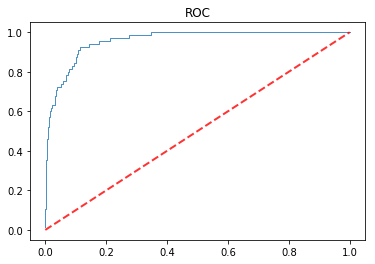

AUC ROC = 0.958648


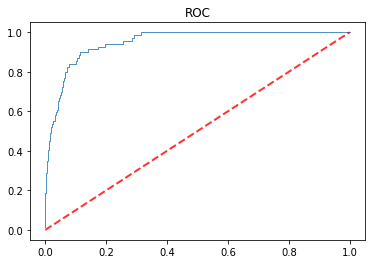

AUC ROC = 0.950908


In [252]:

rand=np.random.randint(10000, size=(10))

for state in rand:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
    LR = LogisticRegression(penalty='l1', C= alpha[idx])
    lreg = LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    fpr,tpr,thresholds, roc_auc = get_auc(X_test,y_test,lreg)
    plt.plot(fpr, tpr, lw=1, alpha=0.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.title('ROC')
    plt.show()
    print("AUC ROC = %f" % roc_auc)


## 7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [247]:

X = df[['student','balance','income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 8) Find the optimal decision tree depth and compute the AUC ROC

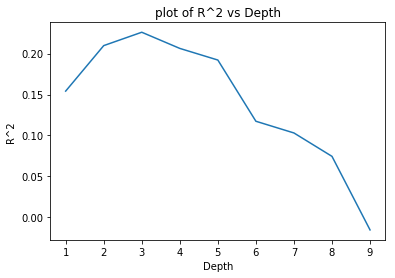

According to the figure shown below, the best decision tree depth is 3.00 


In [248]:
training_errors=[]
test_e=[]
scores=[]
depths = range(1,10)
for n in depths:
    tree = DecisionTreeRegressor(max_depth=n)
    tree.fit(X_train, y_train)
    training_errors.append(tree.score(X_train,y_train))
    scores.append(tree.score(X_test,y_test))
plt.ylabel('R^2 ')
plt.xlabel('Depth')
plt.plot(depths,scores)
plt.title('plot of R^2 vs Depth')
test_e=scores
n_opt=depths[np.argmax(scores)]
plt.show()
print('According to the figure shown below, the best decision tree depth is %0.2f '% (n_opt))

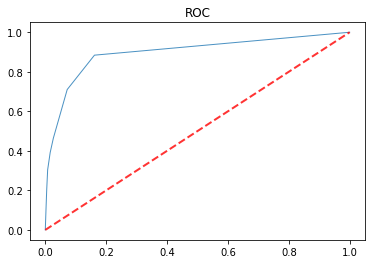

AUC ROC = 0.896562


In [249]:

odt = DecisionTreeClassifier(max_depth=n_opt)
odt.fit(X_train, y_train)
fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,odt)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC')
plt.show()
print("AUC ROC = %f" % roc_auc)